### jupyter Jupiter notebook for LDA (not current - see LDA.py)

In [15]:
from scripts.data_processing import *
from glob import glob
import os
import re
from wordcloud import WordCloud
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from eli5.sklearn import InvertableHashingVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import random


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Create post generator

In [10]:
bzfile = glob(os.path.join('data','*.bz2'))
print(bzfile)
d = data_processing(bzfile, 2500000)

['data\\RC_2011-08.bz2']


### Dat processing steps

In [11]:
data = [l for l in d]
# Remove punctuation
data = [re.sub('[,\\.!?]', '', x) for x in data]
# Convert the titles to lowercase
data = [x.lower() for x in data]
# Remove post with less than 10 words
data = [x for x in data if len(x.split(' '))>10]
# display some data
pprint(data[:3])

['i was thinking 170k max but if we get another player off the books (gibson) '
 'there would be a small bit more room to maneuver',
 'a baton is more likely to kill someone than a taser',
 'cut him a break he probably just finished watching training day ']


### Word Cloud visualization

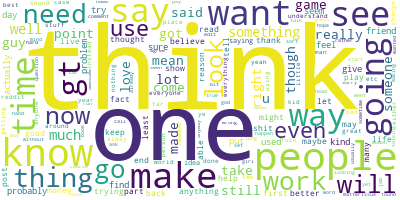

In [12]:
long_string = ','.join(data)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Save the word cloud image
wordcloud.to_file('wordcloud.png')
# Visualize the word cloud
wordcloud.to_image()

In [18]:
### Word freq visualazation and count vectorizer

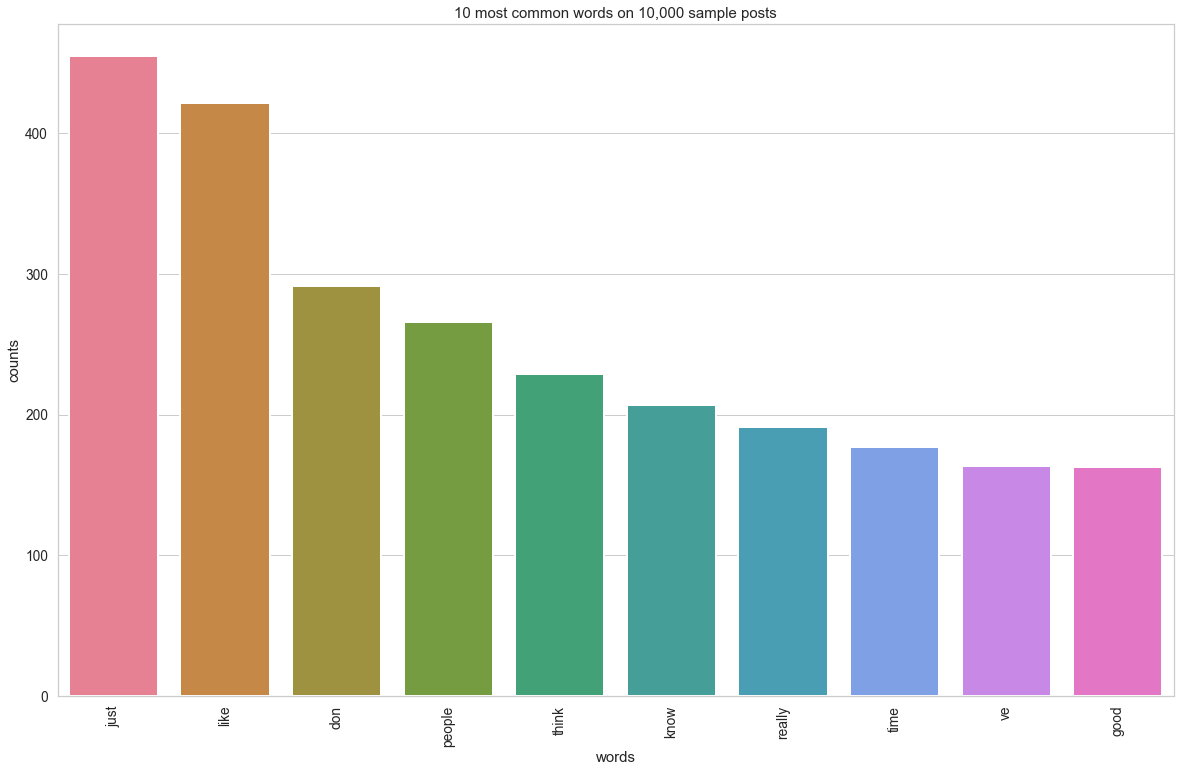

In [21]:

sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0][0]['name'] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    ax = plt.figure(2, figsize=(20, 20/1.6180))
    plt.subplot(title='10 most common words on 10,000 sample posts')
    sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.savefig('top10words.png', bbox_inches='tight', facecolor='white')
    plt.show()
# Initialise the count vectorizer with the English stop words
# count_vectorizer = CountVectorizer(stop_words='english')
# print('fitting hash vectorizer')
hash_vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False)
hash_data = hash_vectorizer.fit_transform(data)
ivec = InvertableHashingVectorizer(hash_vectorizer)
sample_size = 10000
X_sample = random.sample(data, k=sample_size)
print('fitting invertable hash vectorizer')
count_sample = ivec.fit_transform(X_sample)
# # Fit and transform the processed titles
# count_data = count_vectorizer.fit_transform(data)

# Visualise the 10 most common words
#plot_10_most_common_words(count_data, count_vectorizer)
print('plotting top 10 in sample')
plot_10_most_common_words(count_sample, ivec)

### LDA model fit

In [19]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 50
number_words = 10
# Create and fit the LDA model
print(f'fitting the LDA model with {number_topics} topics')
lda = LDA(n_components=number_topics,
          learning_method='online',
          max_iter=10, 
          evaluate_every=3, 
          verbose=1,
          n_jobs=-1)
lda.fit(hash_data)
# lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
# print_topics(lda, count_vectorizer, number_words)
print(f'Displaying top {number_words} words in LDA topics')
print_topics(lda, ivec, number_words)

# save model
import pickle
print('saving model ...', end='')
pickle.dump(lda, 'lda_model.pk')
print('done')

fitting the LDA model with 50 topics


PicklingError: Could not pickle the task to send it to the workers.

In [20]:

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    # with open(LDAvis_data_filepath, 'w') as f:
    #         pickle.dump(LDAvis_prepared, f)
        
    # load the pre-prepared pyLDAvis data from disk
    # with open(LDAvis_data_filepath) as f:
    #     LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

C:\Users\crm0376\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Wall time: 802 ms
